# Portfolio Performance

The results are also hosted on this web page: https://portfolio-performance-fe.vercel.app/

## Data Analysis and Visualization
---
In this script, we use the [pandas](https://pandas.pydata.org/docs/index.html) library to read and manipulate our portfolio data. For data visualization we utilize the [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) module. 


In [5]:
from typing import List, Optional
import math
from pandas import Timestamp, DataFrame, date_range, period_range, read_csv
import matplotlib.pyplot as plt

def create_plot_data(data_frame:DataFrame, title:str, xlabel:str='Date', ylabel:str='USD value'):
    '''
    Creates line charts of the dataset.

    Args:
        data_frame:
            The data to be plotted.
        title:
            The title of the line chart.
        xLabel:
            The measure on the x axis. By default is 'Date'.
        yLabel:
            The measure on the y axis. By default is 'USD value'.
    '''
    plt.figure(figsize=(14, 8))
    for column in data_frame.columns:
        plt.plot(data_frame.index, data_frame[column], label=column)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid(True)

## Portfolio Investment Parameters
---
This section outlines the parameters used in our investment strategy. The initial investment amount, the time frame for the investment, and the list of ETFs included in the portfolio are defined below.

### Initial Investment

The initial investment amount is set to:

- **Investment Amount**: 1,000,000 USD
- Note: This is a self defined constant.

### Investment Period

An investment period is defined by its start and end date:

- **Start Date**: `start_date`
- **End Date**: `end_date`

### Portfolio Composition

The portfolio consists of a list of ETFs:

- **ETFs**: `etfs`

These parameters will be used throughout our analysis to maintain consistency and clarity.

In [6]:
INVESTMENT = 1e6
etf_prices = read_csv('px_etf.csv', parse_dates=['Date'], index_col='Date')
start_date = etf_prices.index[0]
end_date = etf_prices.index[-1]
etfs = etf_prices.columns.values

## ETF Prices
---
The `get_etf_prices` function reads ETF prices from a CSV file, manages any missing data by forward filling, and returns a complete time series of ETF prices within a specified date range.

### Functionality

- **Reads ETF Prices**: 
  The function reads ETF price data from a file named `px_etf.csv`.
  
- **Handles Missing Data**: 
  It fills in any missing dates within the specified date range (`start_date` to `end_date`) using forward filling. This ensures a continuous time series of data.
           
- **Excludes Specified ETFs**: 
  The function can exclude specific ETFs from the dataset if they are listed in the `exclude_etfs` parameter.

### Example of Missing Data:

Consider the following ETF prices (***SPY***, ***IWM***) data with missing dates:
<pre>
    2005-01-06 -> 82.19, 47.49
    2005-01-07 -> 82.07, 46.96
    2005-01-10 -> 82.46, 47.44
    2005-01-11 -> 81.89, 46.86
</pre>

Notice that there are no entries for the dates `2005-01-08` and `2005-01-09`.
After applying the `get_etf_prices` function with forward filling and ***assuming that the price of the ETF remained constant during the missing dates***, the data will be:

<pre>
    2005-01-06 -> 82.19, 47.49
    2005-01-07 -> 82.07, 46.96
    <span style="color:green">2005-01-08 -> 82.07, 46.96</span>
    <span style="color:green">2005-01-09 -> 82.07, 46.96</span>
    2005-01-10 -> 82.46, 47.44
    2005-01-11 -> 81.89, 46.86
</pre>

In [7]:
def get_etf_prices(
    start_date: Timestamp,
    end_date: Timestamp,
    exclude_etfs: Optional[List[str]] = None
) -> DataFrame:
    '''
    Reads ETFs prices from px_etf.csv and fills in the mising dates with forward filling.

    Args:
        start_date: 
            In case of missing data acts as the date from which data should be prefilled.
        end_date: 
            In case of missing data acts as the date until which data should be forward filled.
        exclude_etfs:
            Optional. List of string ETFs to exclude from dataset, by default is empty.

    Returns:
        Returns pandas DataFrame of ETFs prices, where date is the index and ETFs are columns.
    '''
    if exclude_etfs is None:
        exclude_etfs = []
    etf_prices = read_csv('px_etf.csv', parse_dates=['Date'], index_col='Date')
    etf_prices = etf_prices.drop(exclude_etfs, axis=1)
    all_dates = DataFrame(index=date_range(start=start_date, end=end_date, freq='D'))
    etf_prices = etf_prices.reindex(all_dates.index).ffill()

    return etf_prices

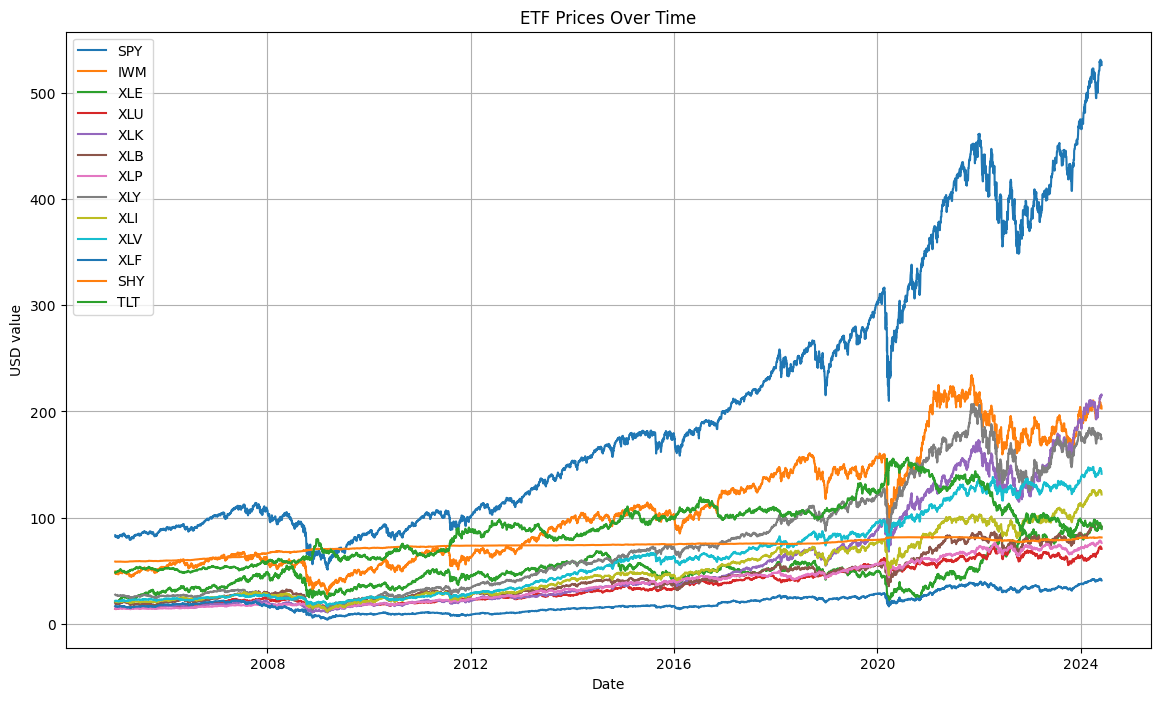

In [8]:
etf_prices = get_etf_prices(start_date, end_date)
create_plot_data(etf_prices, "ETF Prices Over Time")
plt.show()

## ETF quantities
---
The `get_etf_quantities` function reads ETF quantities from a CSV file, fills in any missing data by forward filling, and returns a complete time series of ETF quantities within a specified date range.

Tracks how many units of a specific investment fund (ETF) were bought or sold on a particular date. We adjust the quantity based on the nature of the transaction (buy/sell).

### Functionality

- **Reads Quantities According to ETF Transactions**: 
  The function reads ETF transactions from a `tx_etf.csv` file and adjusts the quantity data.
  
- **Handles Missing Data**: 
  It fills in any missing dates within the specified date range (`start_date` to `end_date`) using forward filling. This ensures a continuous time series of data, similar to the `get_etf_prices` function.
  
- **ETFs Included**: 
  The function ensures that the dataset contains quantities for the ETFs specified in the `etfs` parameter, similar to the `get_etf_prices` function.


In [9]:
def get_etf_quantities(start_date: Timestamp, end_date: Timestamp, etfs: List[str]) -> DataFrame:
    '''
    Reads ETFs quantities from tx_etf.csv and fills in the mising dates with forward filling.

    Args:
        start_date: 
            In case of missing data acts as the date from which data should be prefilled.
        end_date: 
            In case of missing data acts as the date until which data should be forward filled.
        etfs:
            List of string ETFs the dataset should contain.

    Returns:
        Returns pandas DataFrame of ETFs quantities, where date is the index and ETFs are columns.
    '''
    etf_transactions = read_csv('tx_etf.csv', parse_dates=['date'])
    etf_quantities = DataFrame(index=etf_transactions['date'].unique(), columns=etfs)
    prev_date = None
    for _, etf_transaction in etf_transactions.iterrows():
        ticker = etf_transaction['ticker']
        if ticker not in etfs:
            continue
        date = etf_transaction['date']
        qty = etf_transaction['qty']
        order_type = etf_transaction['order']

        if prev_date != date:
            if prev_date is not None:
                etf_quantities.loc[date] = etf_quantities.loc[prev_date]
            else:
                etf_quantities.loc[date] = 0

            prev_date = date

        etf_quantities.at[date, ticker] +=  (qty if order_type == 'BUY' else -qty)

    all_dates = DataFrame(index=date_range(start=start_date, end=end_date, freq='D'))
    etf_quantities = etf_quantities.reindex(all_dates.index).infer_objects().ffill()
    etf_quantities = etf_quantities.astype(int)
    return etf_quantities

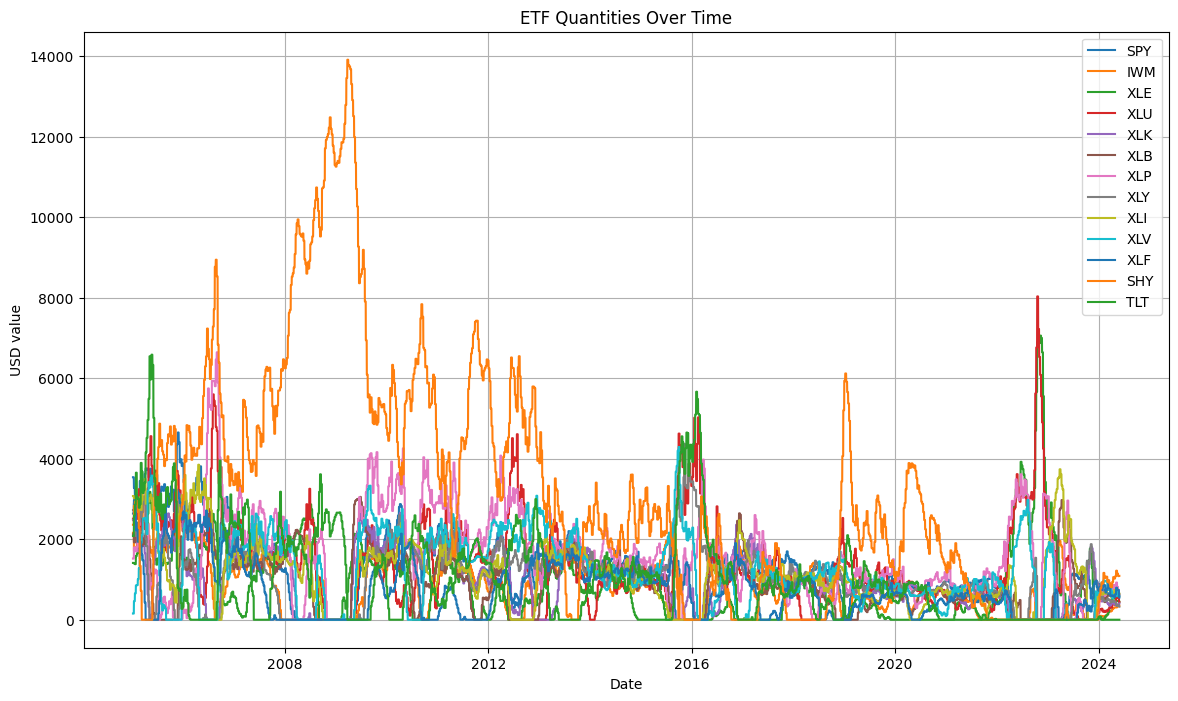

In [10]:
etf_quantities = get_etf_quantities(start_date, end_date, etfs)
create_plot_data(etf_quantities, "ETF Quantities Over Time")
plt.show()

## Cash Flow Calculation
---
The `get_cash_flow` function calculates cash value based on transactions from a CSV file, fills in any missing data using forward filling, and returns a complete time series of cash flow within a specified date range.

It tracks the cash value over time, starting with the `invested_cash` on day one. The cash value is updated based on sell transactions (which increase the cash value) and buy transactions (which decrease the cash value) from the CSV file.

### Functionality

- **Reads and Calculates Cash According to ETF Transactions**: 
  The function reads ETF transactions from a `tx_etf.csv` file and calculates the cash on hand at a certain date.
  
- **Handles Missing Data**: 
  It fills in any missing dates within the specified date range (`start_date` to `end_date`) using forward filling. This ensures a continuous time series of cash flow, similar to the `get_etf_quantities` function.
  
- **Excludes Specified ETFs**: 
  The function can exclude specific ETFs from the dataset if they are listed in the `exclude_etfs` parameter, ensuring flexibility in analyzing cash flow data.


In [11]:
def get_cash_flow(
    etf_prices: DataFrame,
    start_date: Timestamp,
    end_date: Timestamp,
    invested_cash: float,
    exclude_etfs: Optional[List[str]] = None
) -> DataFrame:
    '''
    Updates the cash value by reading the transactions from tx_etf.csv
    and fills in the mising dates with forward filling.

    Args:
        etf_prices:
            The price of ETFS over time.
        start_date: 
            In case of missing data acts as the date from which data should be prefilled.
        end_date:
            In case of missing data acts as the date until which data should be forward filled.
        invested_cash:
            The starting sum of the investment.
        exclude_etfs:
            Optional. List of string ETFs to exclude from dataset, by default is empty.

    Returns:
        Returns pandas DataFrame of cash flow, 
        where date is the index and the cash value is the column.
    '''
    if exclude_etfs is None:
        exclude_etfs = []
    etf_transactions = read_csv('tx_etf.csv', parse_dates=['date'])
    cash_flows = DataFrame(
        index=date_range(start=start_date, end=end_date, freq='D'),
        columns=["value"]
    )
    current_cash = invested_cash
    for _, etf_transaction in etf_transactions.iterrows():
        ticker = etf_transaction['ticker']
        if ticker in exclude_etfs:
            continue

        date = etf_transaction['date']
        qty = etf_transaction['qty']
        price = etf_prices.at[date, ticker]
        order_type = etf_transaction['order']

        current_cash += price * (-qty if order_type == 'BUY' else qty)
        cash_flows.at[date, "value"] = current_cash

    cash_flows = cash_flows.infer_objects().ffill()

    return cash_flows

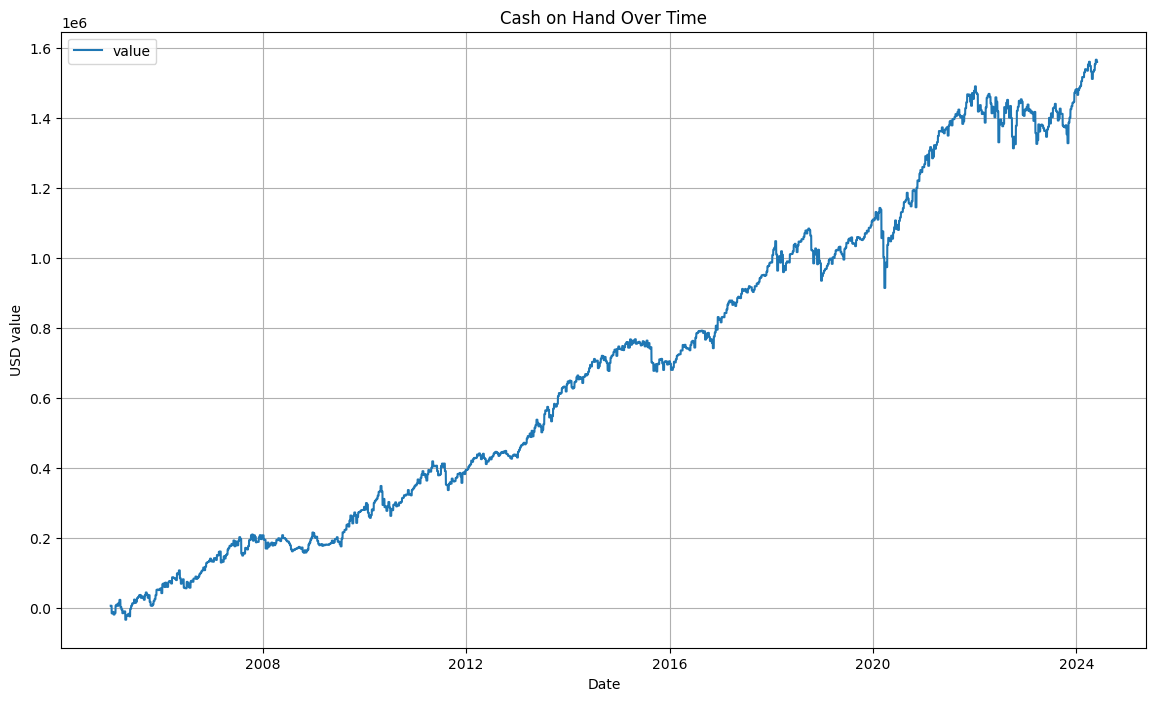

In [12]:
cash_flow = get_cash_flow(etf_prices, start_date, end_date, INVESTMENT)
create_plot_data(cash_flow, "Cash on Hand Over Time")
plt.show()

## Position Value per ETF Calculation
---
The position value of an ETF is equal to the price of the ETF multiplied by the quantity of ETFs at a certain date. The deviations in the line chart are due to transactions involving the buying or selling of ETFs and changes in ETF prices.

**Formula:**

*position*<sub>*i*</sub> = *price*<sub>*i*</sub> × *quantity*<sub>*i*</sub>, where *i* is a certain date.


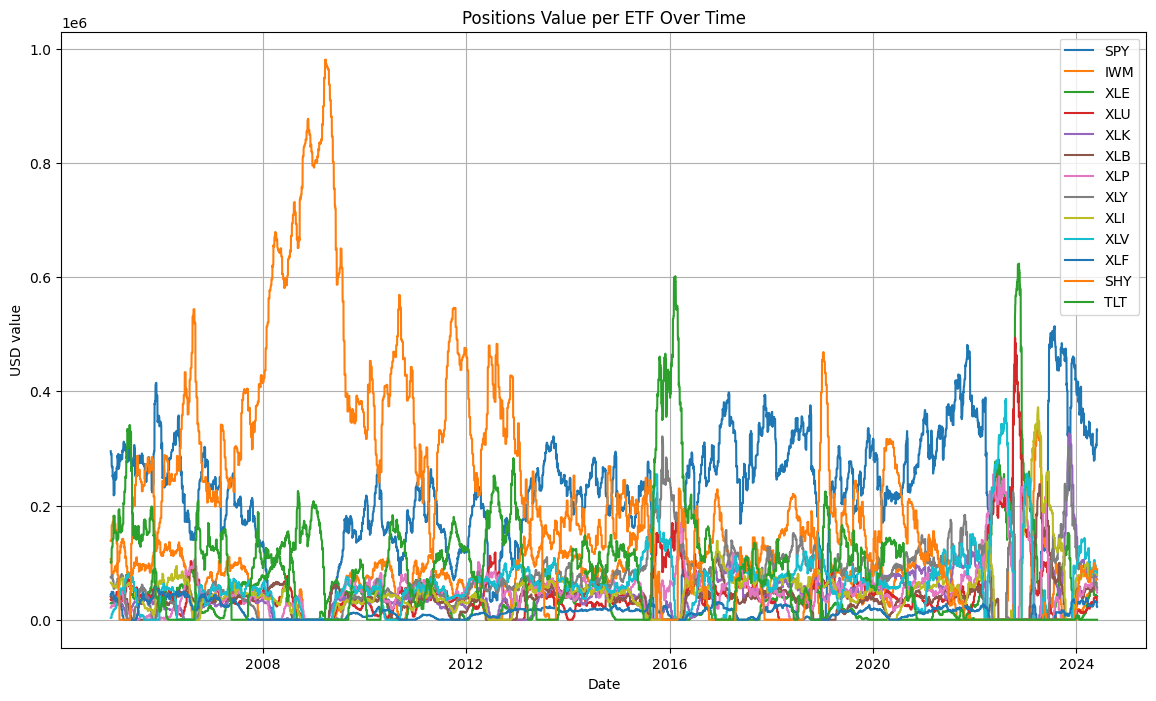

In [13]:
create_plot_data(etf_prices * etf_quantities , "Positions Value per ETF Over Time")
plt.show()

## Positions Value Calculation
---
The position value of the entire portfolio on a given date is calculated by summing up the values of all individual ETFs for that date.

**Formula:**

*position value*<sub>*i*</sub> = &sum;<sub>*e*</sub> (*price*<sub>*ie*</sub> × *quantity*<sub>*ie*</sub>), where *i* represents a certain date and *e* represents each individual ETF in the portfolio.

In [14]:
def get_positions_value(etf_prices: DataFrame, etf_quantities: DataFrame) -> DataFrame:
    '''
    Calculates positions value over time.

    Args:
        etf_prices: 
            The price of ETFS over time.
        etf_quantities: 
            The quantity of ETFS over time.
            
    Returns:
        Returns pandas DataFrame of positions value,
        where date is the index and position value is the column.
    '''
    return DataFrame((etf_prices * etf_quantities).sum(axis=1), columns=["value"])

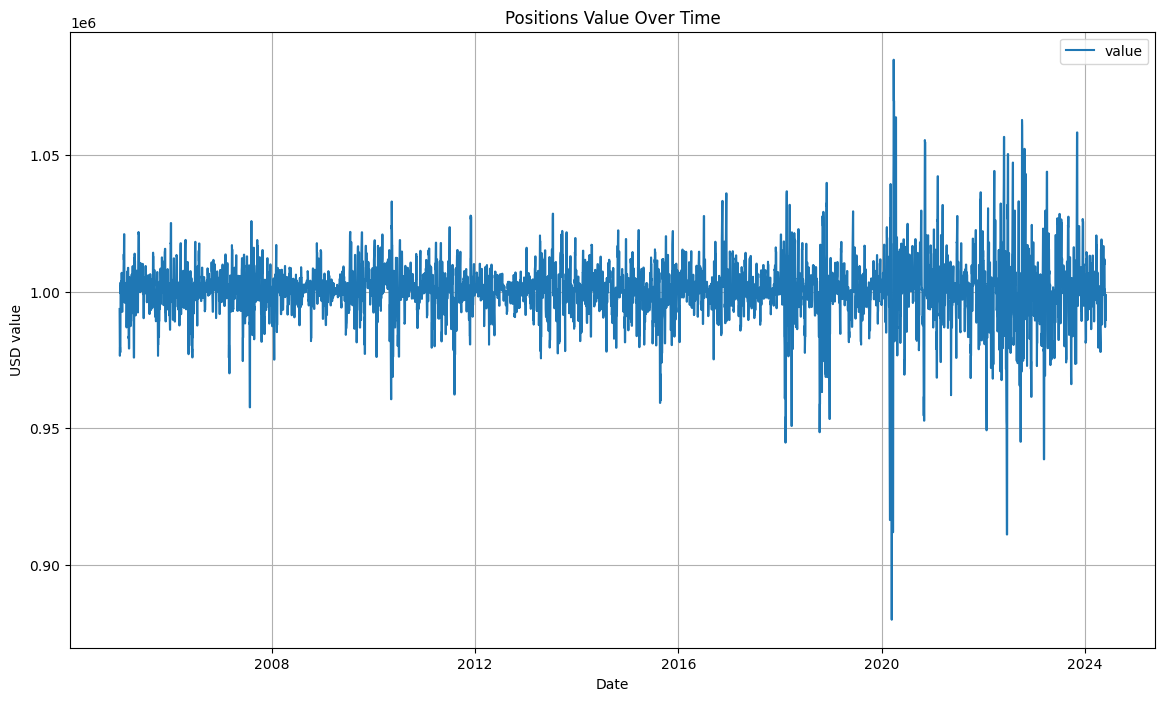

In [15]:
positions_value = get_positions_value(etf_prices, etf_quantities)
create_plot_data(positions_value, "Positions Value Over Time")
plt.show();

## Portfolio Performance Calculation
---
To calculate the **monthly portfolio performance in USD**, we subtract the portfolio value at the beginning of the month from the portfolio value at the end of the month.

**Formula:**

*value* = *value*<sub>*at the end of the month*</sub> - *value*<sub>*at the beginning of the month*</sub>, where the *value* (of the portfolio) is equal to the sum of the positions value and cash on hand.

The **monthly portfolio performance in percentage** is equal to the difference between the portfolio value at the end of the month and the portfolio value at the beginning of the month, divided by the portfolio value at the beginning of the month, multiplied by 100.

**Formula:**

*value* = (*value*<sub>*at the end of the month*</sub> - *value*<sub>*at the beginning of the month*</sub>) / *value*<sub>*at the beginning of the month*</sub> × 100, where the *value* (of the portfolio) is equal to the sum of the positions value and cash on hand.

The **annual portfolio performance** is calculated in a similar way to the monthly performance, but with the portfolio value at the beginning of the year and the portfolio value at the end of the year.

### Example of Monthly Performance:

Let's consider a portfolio consisting of one ETF (XLF) to illustrate the monthly performance.

- We start with 500 USD in cash, and the price of 1 XLF is 40 USD at the beginning of the month.
- Initially, we buy 10 XLF on the first day for a total cost of 10 x 40 USD = 400 USD, leaving us with 100 USD in cash and 400 USD in ETFs.
- The portfolio value at the beginning of the month is 100 USD (cash) + 400 USD (ETFs) = 500 USD.
- After 5 days the XLFs price increases to 42 USD. The portfolio value is 100 USD (cash) + 10 x 42 USD (ETFs) = 520 USD.
- After 10 days, we sell 5 XLFs at 42 USD each, resulting in 100 USD (cash) + 5 x 42 USD = 310 USD in cash and 5 x 42 USD = 210 USD in ETFs.
- After 15 days the XLFs price decreases to 41 USD. The portfolio value is 310 USD (cash) + 5 x 41 USD (ETFs) = 515 USD.
- After 20 days, we buy 5 XLFs at 41 USD each, leaving us with 310 - 5 x 41 USD = 105 USD in cash and 10 x 41 USD = 410 USD in ETFs.
- After 25 days the XLFs price increases to 42 USD. The portfolio value is 105 USD (cash) + 10 x 42 USD (ETFs) = 525 USD.
- At the end of the month, we sell 5 XLFs at 42 USD each, giving us 105 USD + 5 x 42 USD = 315 USD in cash and 5 x 42 USD = 210 USD in ETFs.
- The portfolio value at the end of the month is 315 USD (cash) + 210 USD (ETFs) = 525 USD.
- Therefore, the monthly portfolio performance is 525 USD - 500 USD = 25 USD, indicating a profit of 25 USD.

In [16]:
def get_portfolio_performance(
    positions_value: DataFrame,
    cash_flow: DataFrame,
    start_date: Timestamp,
    end_date: Timestamp,
    freq: str ='Y'
) -> DataFrame:
    '''
    Calculates the portfolio performance.

    Args:
        positions_value:
            The positions value of ETFS over time.
        cash_flow:
            The cash on hand value over time.
        start_date: 
            The starting date of calculating the portfolio performance.
        end_date: 
            The ending date of calculating the portfolio performance.
        freq:
            Accepted values are 'Y' - yearly or 'M' - monthly. By default is 'Y'.
        exclude_etfs:
            List of string ETFs to exclude from dataset.

    Returns:
        Returns pandas DataFrame of portfolio performance in USD and %, 
        where date is the index and portfolio perfoamnce in USD and % are the columns.
        
    Raises: 
        ValueError: Frequency must be either 'M' for monthly portfolio performance 
        or 'Y' for annually portfolio performance
    '''
    if freq not in ['M', 'Y']:
        raise ValueError("Frequency must be either 'M' for monthly portfolio performance "
            "or 'Y' for annually portfolio performance")

    periods = period_range(start=start_date, end=end_date, freq=freq)
    period_tuples = [(period.start_time, period.end_time.floor('D')) for period in periods]
    period_tuples[0] = (start_date, period_tuples[0][1])
    period_tuples[-1] = (period_tuples[-1][0], end_date)

    end_dates = [start_date] + [end_date for _, end_date in period_tuples]
    portfolio_perf = DataFrame(index=end_dates, columns=['USD value', '% value'])
    portfolio_perf.loc[start_date] = 0
    for s_date, e_date in period_tuples:
        start_value = positions_value.at[s_date, 'value'] + cash_flow.at[s_date, 'value']
        end_value = positions_value.at[e_date, 'value'] + cash_flow.at[e_date, 'value']
        portfolio_perf.at[e_date, 'USD value'] = end_value - start_value

        if start_value == 0:
            portfolio_perf.at[e_date, '% value'] = 0
            continue

        portfolio_perf.at[e_date, '% value'] = (end_value - start_value) / start_value * 100

    return portfolio_perf

In [17]:
m_portfolio_perf = get_portfolio_performance(positions_value, cash_flow, start_date, end_date, 'M')
y_portfolio_perf = get_portfolio_performance(positions_value, cash_flow, start_date, end_date, 'Y')

print("Monthly Portfolio Performance")
print(m_portfolio_perf.to_string(index=True, justify='left'))
print("Annually Portfolio Performance")
print(y_portfolio_perf.to_string(index=True, justify='left'))

Monthly Portfolio Performance
           USD value      % value  
2005-01-03              0         0
2005-01-31    -8382.36318 -0.838236
2005-02-28   11020.460302  1.106761
2005-03-31  -18977.284145 -1.878362
2005-04-30  -10078.425315 -1.019461
2005-05-31    28229.82317  2.884936
2005-06-30    1958.366262   0.19282
2005-07-31   18950.737165  1.862016
2005-08-31    1866.597891  0.180212
2005-09-30   -1362.144875 -0.131268
2005-10-31  -22322.257441 -2.153994
2005-11-30   26545.126829  2.616902
2005-12-31   -9112.926308 -0.866839
2006-01-31   27033.497782  2.593964
2006-02-28   -1463.196033 -0.136498
2006-03-31    7339.571703  0.681017
2006-04-30   10876.765144  1.002396
2006-05-31  -19842.142866 -1.817189
2006-06-30   -4965.295755 -0.460006
2006-07-31     1656.60274  0.154184
2006-08-31   10498.522349  0.976171
2006-09-30    6341.939893  0.582098
2006-10-31   20083.074386  1.832665
2006-11-30   20106.666767  1.808084
2006-12-31    4636.763435  0.410025
2007-01-31   10044.147703  0.88456

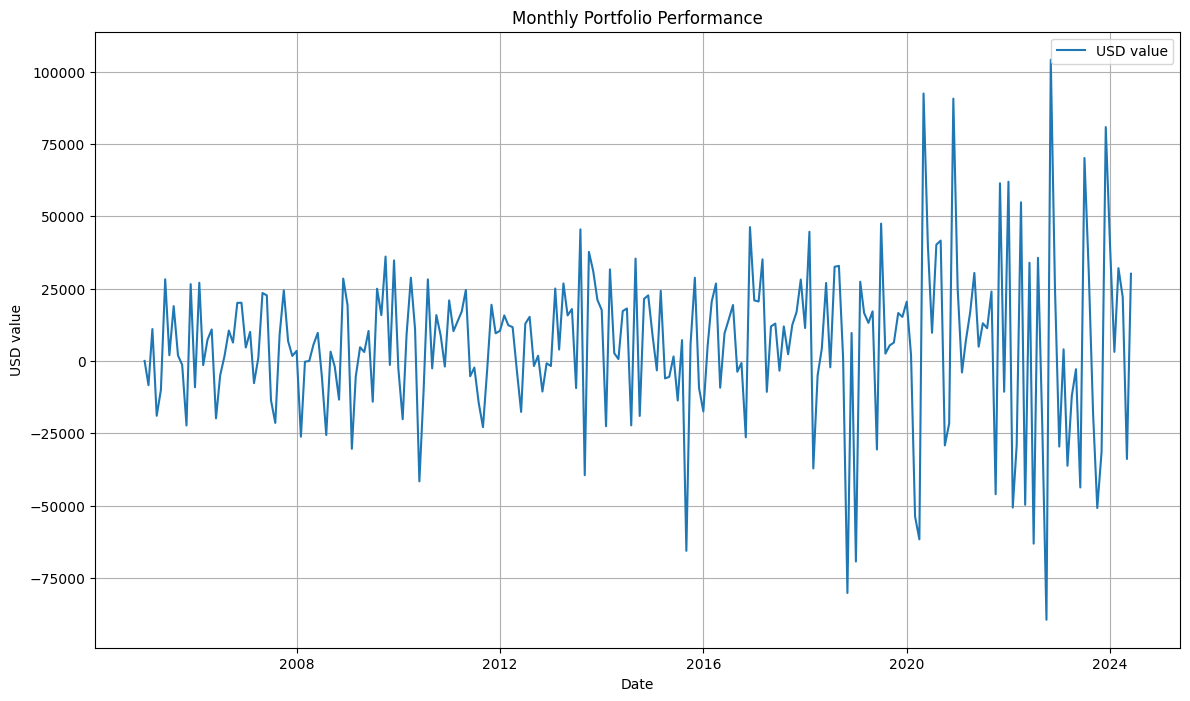

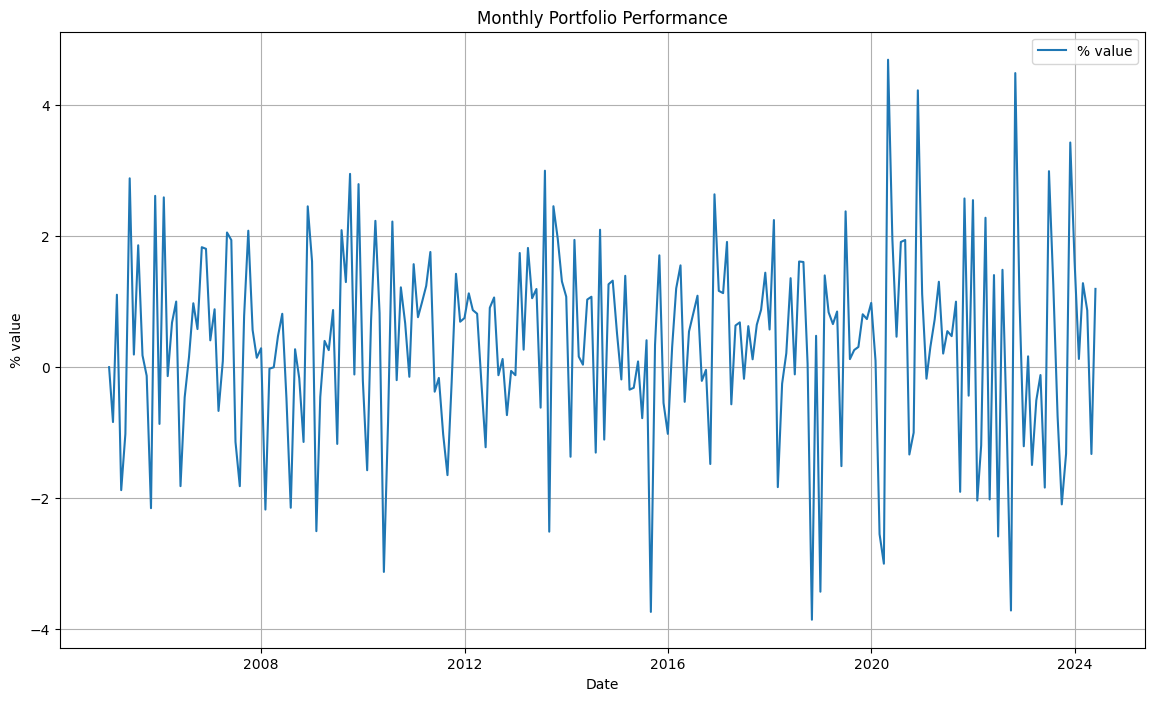

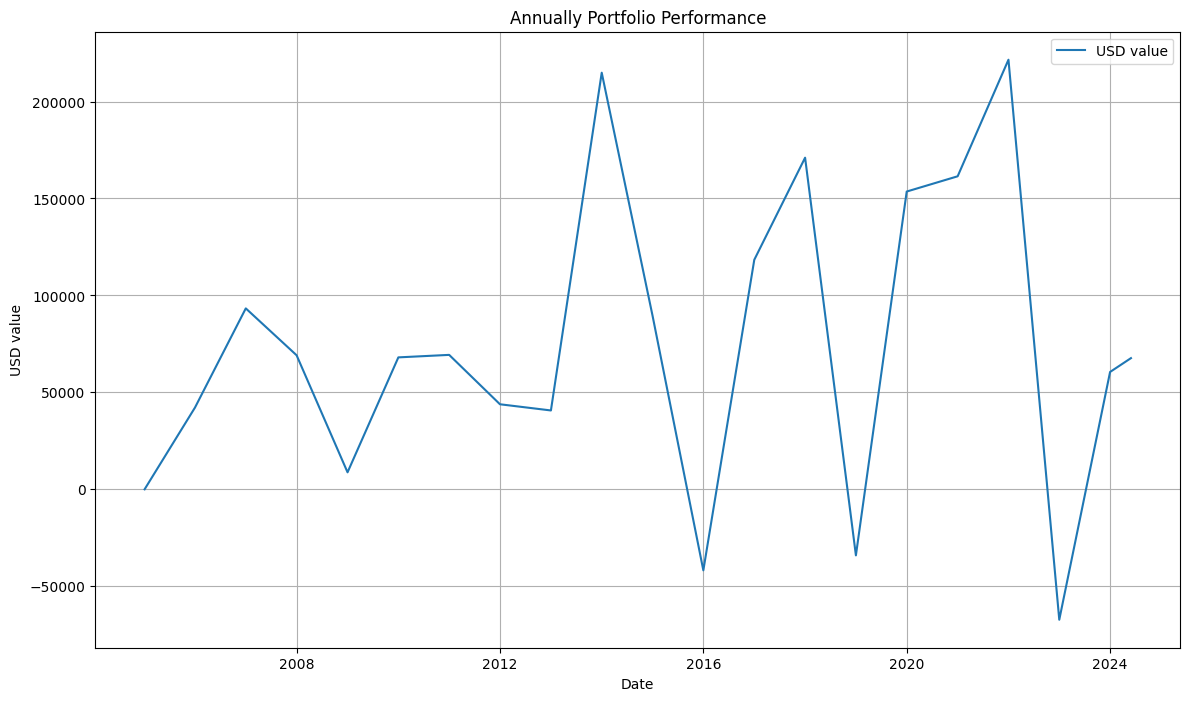

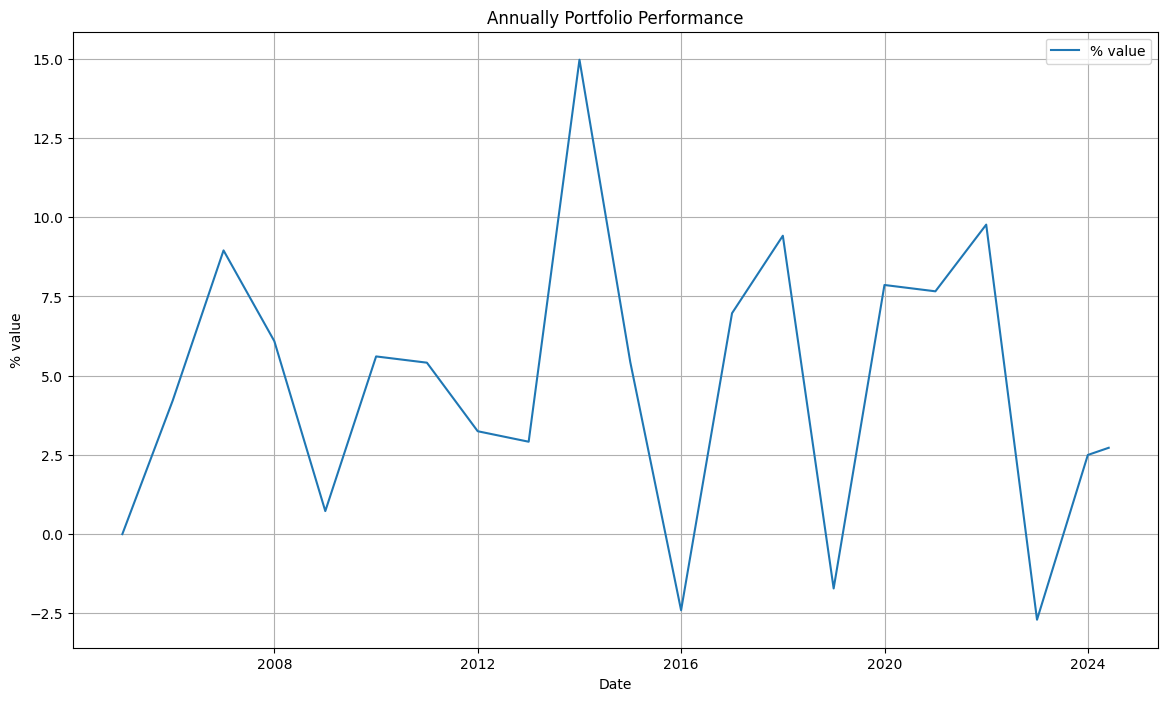

In [18]:
m_portfolio_perf_usd = m_portfolio_perf.drop(columns=['% value'])
m_portfolio_perf_perc = m_portfolio_perf.drop(columns=['USD value'])
y_portfolio_perf_usd = y_portfolio_perf.drop(columns=['% value'])
y_portfolio_perf_perc = y_portfolio_perf.drop(columns=['USD value'])
create_plot_data(m_portfolio_perf_usd, "Monthly Portfolio Performance")
create_plot_data(m_portfolio_perf_perc, "Monthly Portfolio Performance", ylabel='% value')
create_plot_data(y_portfolio_perf_usd, "Annually Portfolio Performance")
create_plot_data(y_portfolio_perf_perc, "Annually Portfolio Performance", ylabel='% value')

## Standard Deviation of Daily Returns Calculation
---
Standard deviation is calculated by taking the square root of a value derived from comparing data points to a collective mean of daily returns.

**Formula:**

*std_daily_returns* = √(∑(𝑥<sub>𝑖</sub> - 𝑥̄)<sup>2</sup> / (*n* - 1))
<pre>
𝑥<sub>𝑖</sub> - The daily return on the 𝑖<sup>th</sup> date
𝑥̄ - The mean value of the daily returns
<i>n</i> - The number of daily returns
</pre>

Reference: [Investopedia - Standard Deviation](https://www.investopedia.com/terms/s/standarddeviation.asp)

In [19]:
def get_standard_deviation_of_daily_returns(
    positions_value: DataFrame,
    cash_flow: DataFrame
) -> DataFrame:
    '''
    Calculates the standard deviation of daily returns.

    Args:
        positions_value:
            The positions value of ETFS over time.
        cash_flow:
            The cash on hand value over time.

    Returns:
        Returns the standard deviation of daily returns as a float number.
    '''
    portfolio_values = positions_value + cash_flow
    beginning_values = portfolio_values.shift(1)
    daily_returns = (portfolio_values - beginning_values) / beginning_values * 100

    standard_deviation = calculate_standard_deviation(daily_returns)
    return standard_deviation

def calculate_standard_deviation(data: DataFrame) -> float:
    '''Calculates and returns the standard deviation of a dataset.'''
    mean = data.mean()
    n = len(data)

    deviation_from_mean = mean - data
    deviation_from_mean = deviation_from_mean ** 2

    sum_deviation_from_mean = deviation_from_mean.sum().iloc[0]

    standard_deviation = math.sqrt(sum_deviation_from_mean / (n - 1))

    return standard_deviation

In [20]:
standard_deviation_of_daily_returns = get_standard_deviation_of_daily_returns(positions_value, cash_flow)
print(f"Standard deviation value of the portfolio daily returns: {standard_deviation_of_daily_returns}")

Standard deviation value of the portfolio daily returns: 0.3237857483393154


## Portfolio Highlights:
---
- The prices of ETFs have generally shown an upward trajectory over the years, indicating positive market trends.
- Using a buy-sell strategy, after almost 20 years, the portfolio has approximately 1,500,000 USD in cash and 1,000,000 USD in ETFs, indicating profitability.
- On April 30, 2020, the monthly portfolio's performance was at its peak, with a gain of 4.696478% to the previous month.
- On October 31, 2018, the portfolio experienced its worst monthly performance, with a loss of 3.857687% (-3.857687% gain) to the previous month.
- The year 2022 had the worst performance, with a 2.7016% loss (-2.7016% gain) compared to the previous year.
- The most profitable years were 2017 and 2013, with increased returns of 14.97205% and 9.768108% compared to the previous years.
- The standard deviations of daily returns is 0.3237, indicating consistent and stable returns.

Overall, the analysis suggests that the portfolio has been profitable, with consistent returns and mostly a steady increase in value over the years.